In [1]:
!pip install lightgbm
!pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sea
import random
import scipy.stats as stats
import xgboost
from collections import defaultdict
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, explained_variance_score, r2_score, classification_report
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import SCORERS
import warnings; warnings.simplefilter('ignore')

data = pd.read_csv('movies_metadata.csv')
data.drop(['belongs_to_collection', 'homepage', 'original_title', 'overview','production_companies' , 'tagline', 'status', 'video', 'id', 'imdb_id'],axis=1,inplace=True)
data.dropna(inplace=True)
data['budget'] = data['budget'].astype(np.float)
data['popularity'] = data['popularity'].astype(np.float)
data = data[~(data == 0).any(axis=1)]
#data['loggross'] = np.log1p(data['revenue'])
#data['revenuemillions'] = data['revenue']/1000000

data['genres'] = data['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
#data['production_companies'] = data['production_companies'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
data['production_countries'] = data['production_countries'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
data['spoken_languages'] = data['spoken_languages'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

data['poster_path'].fillna(0, inplace=True)
data.loc[data['poster_path'] != 0, 'poster_path'] = 1

data['genres'] = data['genres'].map(lambda x: str(x)[:-1])
data['genres'] = data['genres'].map(lambda x: str(x)[1:])

#data['production_countries'] = data['production_countries'].map(lambda x: str(x)[:-1])
#data['production_countries'] = data['production_countries'].map(lambda x: str(x)[1:])

#data['spoken_languages'] = data['spoken_languages'].map(lambda x: str(x)[:-1])
#data['spoken_languages'] = data['spoken_languages'].map(lambda x: str(x)[1:])


In [2]:
data['release_date'] = pd.to_datetime(data['release_date'], infer_datetime_format=True)
data['day'] = data['release_date'].apply(lambda t: t.day)
data['weekday'] = data['release_date'].apply(lambda t: t.weekday())
data['month'] = data['release_date'].apply(lambda t: t.month)
data['year'] = data['release_date'].apply(lambda t: t.year if t.year < 2018 else t.year -100)
# Year was being interpreted as future dates in some cases so I had to adjust some values


In [3]:
#data[['release_date','day','week','month','year']].head()
#sea.countplot(x='day',data=data)
#sea.countplot(x='weekday',data=data)
#sea.countplot(x='month',data=data)
#plt.figure(figsize=(25,15))
#sea.countplot(x='year',data=data)
#plt.xticks(rotation=90)

X = data[data['budget'] != 0]
for i in X.select_dtypes(include='number', exclude='datetime'):
    print(i, stats.pearsonr(X.budget, X[i]))

budget (1.0, 0.0)
popularity (0.3071516772660544, 1.633594934752139e-117)
poster_path (nan, 1.0)
revenue (0.7299914747137763, 0.0)
runtime (0.19108877683786404, 2.8745731959592137e-45)
vote_average (-0.013256789119359867, 0.33177057205340066)
vote_count (0.5860845154191411, 0.0)
day (0.032231196436209766, 0.01826438864150039)
weekday (-0.13462961495943623, 4.1150890487167184e-23)
month (0.02503400973423872, 0.06680373071447869)
year (0.26580236416433906, 2.1435284304329103e-87)


In [4]:
# vote count and popularity correlate most strongly with budget
def map_budget(df):
    d = defaultdict()
    #df['budget'] = df['budget'].fillna(0)
    X = data[data['budget'] != 0]
    
    vote_count_mean = pd.Series(X.groupby(['vote_count'])['budget'].agg('mean'))
    d = dict(vote_count_mean)
    
    for i in data[data['budget'] == 0]:
        data['budget'] = data.loc[:, 'vote_count'].map(d)
    
    return data



In [5]:
data = map_budget(data)
data.budget.describe()

count    5.362000e+03
mean     3.118646e+07
std      3.605405e+07
min      1.000000e+00
25%      1.113333e+07
50%      1.975000e+07
75%      3.500000e+07
max      3.800000e+08
Name: budget, dtype: float64

In [6]:
genres= data.genres.str.get_dummies(sep=',')
data =pd.concat([data,genres],axis=1)
data.drop(['genres'],axis=1,inplace=True)
#data.head()

In [7]:
company = data.production_countries.str.get_dummies(sep=',')

data =pd.concat([data,company],axis=1)
data.drop(['production_countries'],axis=1,inplace=True)
#data.head()

In [8]:
language = pd.get_dummies(data['original_language'])

data = pd.concat([data, language], axis=1)      
data.drop(['original_language'], inplace=True, axis=1)

In [9]:
data.drop(['adult', 'release_date', 'spoken_languages', 'title'],axis=1,inplace=True)

In [10]:
data.dtypes

budget                float64
popularity            float64
poster_path             int64
revenue               float64
runtime               float64
vote_average          float64
vote_count            float64
day                     int64
weekday                 int64
month                   int64
year                    int64
 'Action'               int64
 'Adventure'            int64
 'Animation'            int64
 'Comedy'               int64
 'Crime'                int64
 'Documentary'          int64
 'Drama'                int64
 'Family'               int64
 'Fantasy'              int64
 'Foreign'              int64
 'History'              int64
 'Horror'               int64
 'Music'                int64
 'Mystery'              int64
 'Romance'              int64
 'Science Fiction'      int64
 'Thriller'             int64
 'War'                  int64
 'Western'              int64
                       ...   
fi                      uint8
fr                      uint8
he        

In [11]:
database = data.drop(['revenue'],axis=1)
target = data['revenue']

train_data, test_data, train_target, test_target = train_test_split(database, target, test_size = 0.4, random_state = 0)

#DecisionTreeRegressorModel = tree.DecisionTreeRegressor()
#regression_with_cross_validation(DecisionTreeRegressorModel, preprocessed_data, target_gross, 5, "Decision Tree Regression", "(Movie Gross Prediction)")
#regr_without_cross_validation_train_test_perform_plot(DecisionTreeRegressorModel, database, target, "Decision Tree Regression", "(Movie Gross Prediction)")

print("Shape of X_train is : ",train_data.shape[0])
print("Shape of y_train is : ",train_target.shape[0])
print("Shape of X_test is : ",test_data.shape[0])
print("Shape of y_test is : ",test_target.shape[0])


Shape of X_train is :  3217
Shape of y_train is :  3217
Shape of X_test is :  2145
Shape of y_test is :  2145


In [12]:
LinearReg = LinearRegression()
LinearReg.fit(train_data,train_target)
Prediction = LinearReg.predict(test_data)


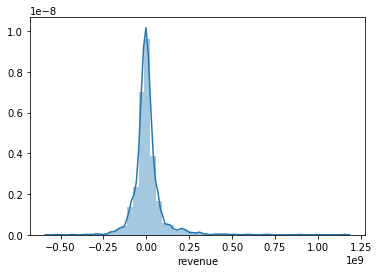

Mean Absolute Error: 49862614.24186491
Mean Squared Error: 8239718785115552.0
Median Absolute Error: 27889616.86913371
Explained Var Score: 0.7355735907176135
R^2 Score: 0.7346182567992485
Root Mean Squared Error: 90772896.75401767
Root Mean Squared Logarithmic Error: 1.85277454475895


3181     36037909.0
22655       75143.0
3198     32168970.0
34536       25000.0
4673     10600000.0
Name: revenue, dtype: float64

In [13]:
sea.distplot((test_target-Prediction),bins=50)
plt.show()

print('Mean Absolute Error:', metrics.mean_absolute_error(test_target, Prediction))
print('Mean Squared Error:', metrics.mean_squared_error(test_target, Prediction))
print('Median Absolute Error:', metrics.median_absolute_error(test_target, Prediction))
print('Explained Var Score:', metrics.explained_variance_score(test_target, Prediction))
print('R^2 Score:', metrics.r2_score(test_target, Prediction))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_target, Prediction)))
print('Root Mean Squared Logarithmic Error:', np.sqrt(np.mean(np.power(np.log1p(Prediction) - np.log1p(test_target), 2))))

test_target.head()

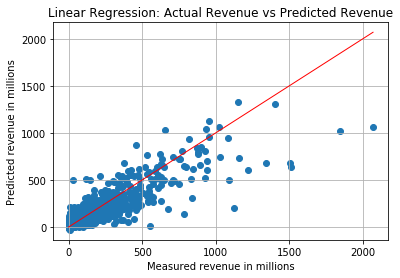

In [14]:
def rmsle(train_target, Prediction):
    return 'rmsle', np.sqrt(np.mean(np.power(np.log1p(Prediction) - np.log1p(train_target), 2))), False
LinearReg = LGBMRegressor(boosting_type='dart',num_leaves=20,max_depth=-1,min_data_in_leaf=20, learning_rate=0.2,n_estimators=500,subsample_for_bin=200000,
                   class_weight=None,min_split_gain=0.0,min_child_weight=0.001,subsample=0.1,subsample_freq=0,colsample_bytree=0.75,reg_alpha=0.0,reg_lambda=0.0,
                   random_state=101,n_jobs=-1)
LinearReg.fit(train_data, train_target,eval_set=[(test_data, test_target)],eval_metric=rmsle,verbose=False)
Prediction = LinearReg.predict(test_data, num_iteration=LinearReg.best_iteration_)

fig, ax = plt.subplots()
test_target = test_target/1000000
Prediction = Prediction/1000000
ax.scatter(test_target, Prediction)
ax.plot([test_target.min(), test_target.max()], [test_target.min(), test_target.max()], lw=1, color = 'r')
ax.set_xlabel('Measured revenue in millions')
ax.set_ylabel('Predicted revenue in millions')
plt.title("Linear Regression: Actual Revenue vs Predicted Revenue" )
plt.grid()
plt.show()

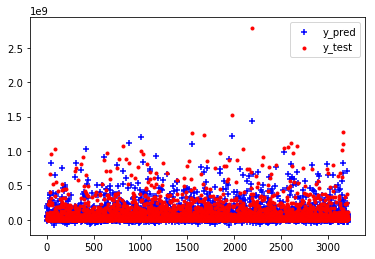

In [15]:
lm = LinearRegression()
lm.fit(train_data, train_target)
lm.score(test_data, test_target)
y_pred2 = lm.predict(train_data)
#print(y_pred2.shape)
#for i in range(y_pred2.shape[0]):
#    print(y_pred2[i], Y_test2[i], X_test2[i])
y = range(y_pred2.shape[0])

plt.scatter(y, y_pred2, c='b', marker='+')
plt.scatter(y, train_target, c='r', marker='.')
labels = ['y_pred', 'y_test']
plt.legend(labels)

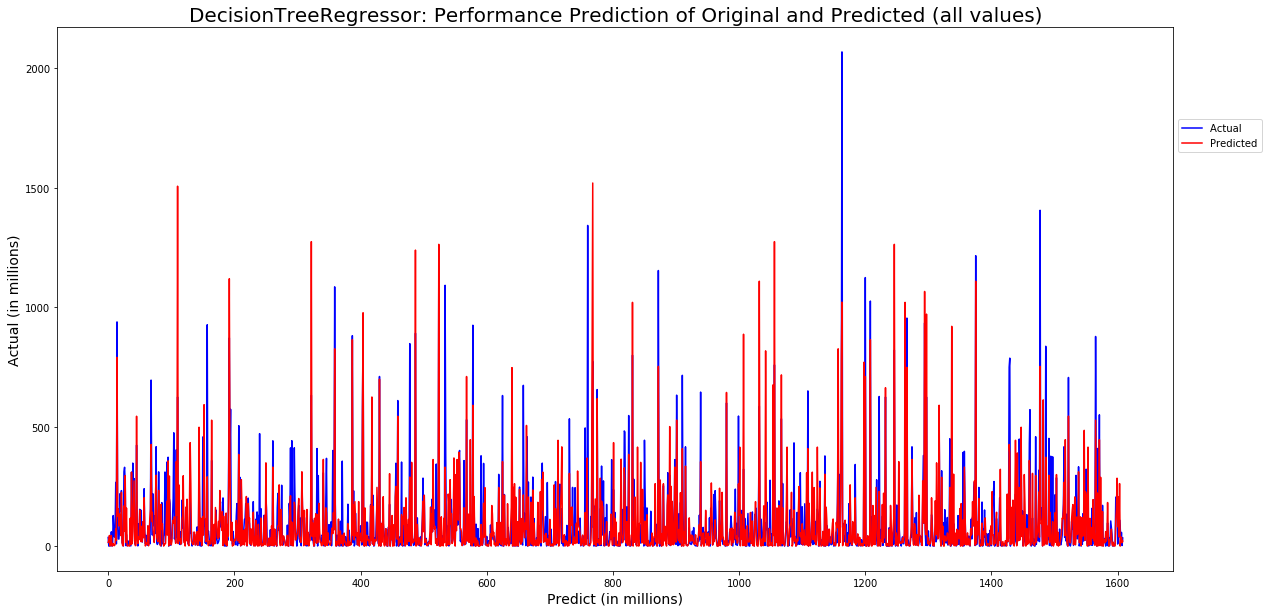

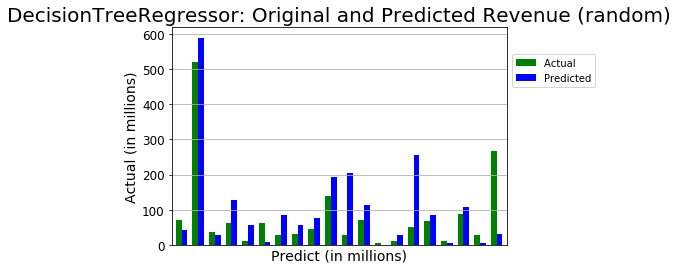

Regression Scores(train_test_split):

Mean Absolute Error    : 61.281754990677435
Mean Squared Error     : 14163.596872901886
Median Absolute Error  : 23.985955999999998
Explained Var Score    : 0.5340558903906742
R^2 Score              : 0.5338482213542584


In [42]:
DecisionTreeRegressorModel = tree.DecisionTreeRegressor()
train_data, test_data, train_target, test_target = train_test_split(database, target, test_size = 0.3, random_state = 0) 
DecisionTreeRegressorModel.fit(train_data, train_target)
prediction = DecisionTreeRegressorModel.predict(test_data)

original = np.asarray(test_target)

#print(original)
#print(prediction)
original = original/1000000
prediction = prediction/1000000

plt.figure(figsize=(20,10))
plt.title('DecisionTreeRegressor: Performance Prediction of Original and Predicted (all values)',fontsize = 20)
plt.plot(original, c = 'blue')
plt.plot(prediction, c = 'red')
plt.ylabel('Actual (in millions)', fontsize = 14)
plt.xlabel('Predict (in millions)', fontsize = 14)
plt.legend(["Actual ", "Predicted"], loc = 'center left', bbox_to_anchor = (1, 0.8))
plt.show()

original_val_list = []
predicted_val_list = []
for k in range(20):
    i = random.randint(0, len(prediction) - 1)
    original_val_list.append(original[i])
    predicted_val_list.append(prediction[i])
    
original_val_df = pd.DataFrame(original_val_list)
predicted_val_df = pd.DataFrame(predicted_val_list)
    
actual_vs_predicted = pd.concat([original_val_df, predicted_val_df], axis = 1)
    
actual_vs_predicted.plot(kind = "bar", fontsize = 12, color = ['g','b'], width= 0.7)
plt.title('DecisionTreeRegressor: Original and Predicted Revenue (random)',fontsize = 20)
plt.ylabel('Actual (in millions)', fontsize = 14)
plt.xlabel('Predict (in millions)', fontsize = 14)
plt.xticks([])
plt.legend(["Actual ", "Predicted"], loc = 'center left', bbox_to_anchor = (1, 0.8))
plt.grid()
plt.show()

mean_abs_error = mean_absolute_error(original, prediction) 
mean_sqr_error = mean_squared_error(original, prediction)
median_abs_error = median_absolute_error(original, prediction)
explained_var_score = explained_variance_score(original, prediction)
r2__score = r2_score(original, prediction)
print("Regression Scores(train_test_split):\n")
print("Mean Absolute Error    :", mean_abs_error)
print("Mean Squared Error     :", mean_sqr_error)
print("Median Absolute Error  :", median_abs_error)
print("Explained Var Score    :", explained_var_score)
print("R^2 Score              :", r2__score)

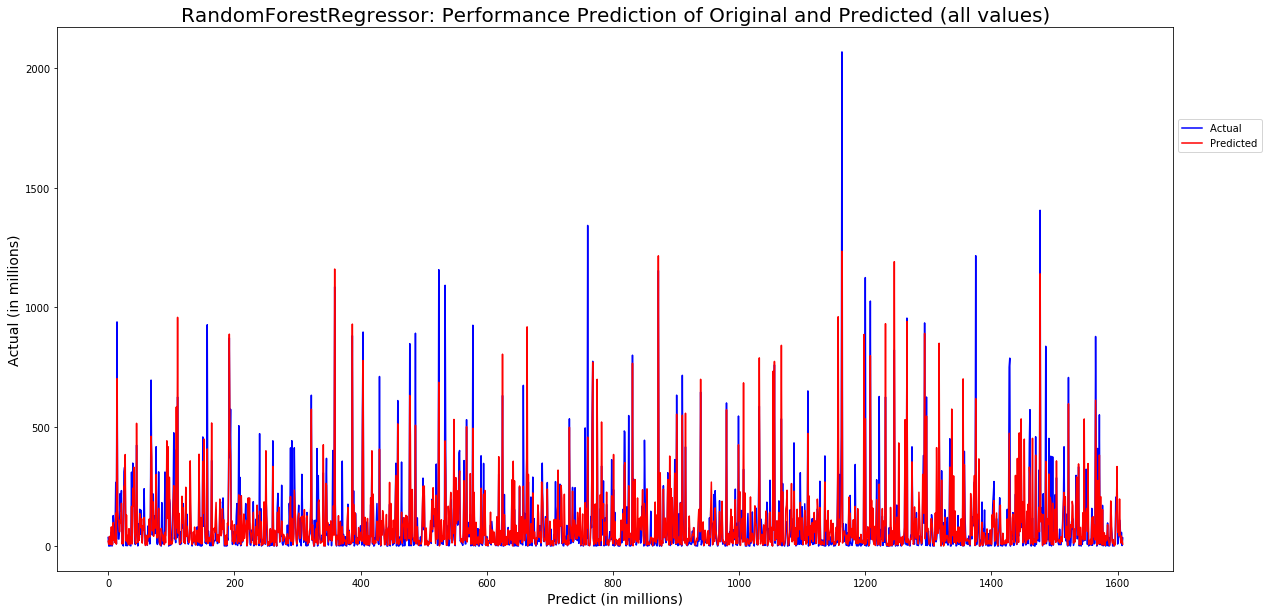

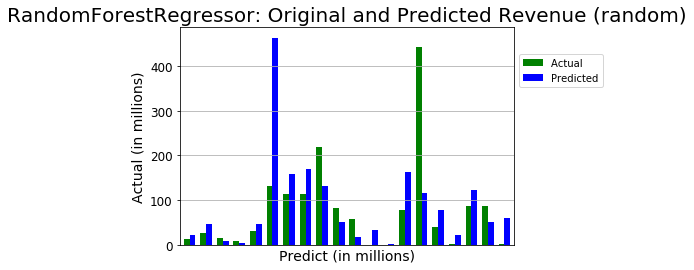

Regression Scores(train_test_split):

Mean Absolute Error    : 46.72770384853947
Mean Squared Error     : 8006.715506365573
Median Absolute Error  : 20.162478000000004
Explained Var Score    : 0.7365036809690632
R^2 Score              : 0.7364832741361371


In [43]:
randomForestRegressorModel = RandomForestRegressor()
train_data, test_data, train_target, test_target = train_test_split(database, target, test_size = 0.3, random_state = 0) 
randomForestRegressorModel.fit(train_data, train_target)
prediction = randomForestRegressorModel.predict(test_data)

original = np.asarray(test_target)

#print(original)
#print(prediction)
original = original/1000000
prediction = prediction/1000000

plt.figure(figsize=(20,10))
plt.title('RandomForestRegressor: Performance Prediction of Original and Predicted (all values)',fontsize = 20)
plt.plot(original, c = 'blue')
plt.plot(prediction, c = 'red')
plt.ylabel('Actual (in millions)', fontsize = 14)
plt.xlabel('Predict (in millions)', fontsize = 14)
plt.legend(["Actual ", "Predicted"], loc = 'center left', bbox_to_anchor = (1, 0.8))
plt.show()

original_val_list = []
predicted_val_list = []
for k in range(20):
    i = random.randint(0, len(prediction) - 1)
    original_val_list.append(original[i])
    predicted_val_list.append(prediction[i])
    
original_val_df = pd.DataFrame(original_val_list)
predicted_val_df = pd.DataFrame(predicted_val_list)
    
actual_vs_predicted = pd.concat([original_val_df, predicted_val_df], axis = 1)
    
actual_vs_predicted.plot(kind = "bar", fontsize = 12, color = ['g','b'], width= 0.7)
plt.title('RandomForestRegressor: Original and Predicted Revenue (random)',fontsize = 20)
plt.ylabel('Actual (in millions)', fontsize = 14)
plt.xlabel('Predict (in millions)', fontsize = 14)
plt.xticks([])
plt.legend(["Actual ", "Predicted"], loc = 'center left', bbox_to_anchor = (1, 0.8))
plt.grid()
plt.show()

mean_abs_error = mean_absolute_error(original, prediction) 
mean_sqr_error = mean_squared_error(original, prediction)
median_abs_error = median_absolute_error(original, prediction)
explained_var_score = explained_variance_score(original, prediction)
r2__score = r2_score(original, prediction)
print("Regression Scores(train_test_split):\n")
print("Mean Absolute Error    :", mean_abs_error)
print("Mean Squared Error     :", mean_sqr_error)
print("Median Absolute Error  :", median_abs_error)
print("Explained Var Score    :", explained_var_score)
print("R^2 Score              :", r2__score)
